## MA755 - 7 Feb 2017

Material from _Chapter 1. End-to-end Machine Learning project_ of

> "[Hands-On Machine Learning with Scikit-Learn and TensorFlow](http://shop.oreilly.com/product/0636920052289.do)"<br>
by Aurélien Géron
Published by O'Reilly Media, Inc., 2017

We are going to built a model that predicts how much money 
We are using the collegue score dataset

State the problem
Select method - regressioin
Select score funtion RMSE or MAE

In [1]:
%load_ext watermark
%watermark -d -v -m -p numpy,pandas,matplotlib,scikit-learn

2017-02-09 

CPython 3.5.1
IPython 4.2.0

numpy 1.12.0
pandas 0.18.1
matplotlib 2.0.0
scikit-learn 0.18.1

compiler   : MSC v.1900 64 bit (AMD64)
system     : Windows
release    : 7
machine    : AMD64
processor  : Intel64 Family 6 Model 58 Stepping 9, GenuineIntel
CPU cores  : 4
interpreter: 64bit


First, we are going to get the data from 'https://collegescorecard.ed.gov/data/'. Data is compress in a zip file so we'll create a funtion to download and extract the data 

In [2]:
import os
import zipfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://ed-public-download.apps.cloud.gov/downloads/"
COLLEGE_PATH = "datasets/collegescorecard"
COLLEGE_URL = DOWNLOAD_ROOT+ "/CollegeScorecard_Raw_Data.zip"

def fetch_housing_data(college_url=COLLEGE_URL, college_path=COLLEGE_PATH):
    os.makedirs(college_path, exist_ok=True)
    zip_path = os.path.join(college_path, "CollegeScorecard_Raw_Data.zip")
    urllib.request.urlretrieve(college_url, zip_path)
    college_zip = zipfile.ZipFile(zip_path, 'r')
    college_zip.extractall(path=college_path)
    college_zip.close()

In [ ]:
#fetch_housing_data()

The files is now downloaded into __datasets\collegescorecard\CollegeScorecard_Raw_Data__ folder. We have 1 file per year so we need to read them all and concatenate them to end up with just one file.

In [3]:
import pandas as pd
from os import listdir
from os.path import isfile, join

def load_college_data(college_path=COLLEGE_PATH+'/CollegeScorecard_Raw_Data', string_include = "" ):
    college_list = []
    #get list of files in directory that are .csv and starting 2000 (memory issues)
    onlyfiles = [f for f in listdir(college_path) if (isfile(join(college_path, f))) and (".csv" in f) and ("201" in f)]
    for f in onlyfiles:
        print("Reading %s ..." %f)
        csv_path = os.path.join(college_path, f)
        aux = pd.read_csv(csv_path,low_memory=False)
        aux['YEAR']=int(f.split('MERGED')[1].split('_')[0])
        college_list.append(aux)
        del aux 
    print("Concatenating files ...")    
    return pd.concat(college_list)

Load the data from the `housing.csv` file into a `DataFrame` Pandas object stored in `housing`. 

In [6]:
college = load_college_data(string_include="201")

Reading MERGED2010_11_PP.csv ...
Reading MERGED2011_12_PP.csv ...
Reading MERGED2012_13_PP.csv ...
Reading MERGED2013_14_PP.csv ...
Reading MERGED2014_15_PP.csv ...
Concatenating files ...


Now we have one files with all the data. We save the notebook so we don't have to download the data and concatenate it again: Let's check how big is our dataframe and inpect the first 5 lines

In [7]:
college.to_csv(COLLEGE_PATH+'/college.csv',index=False)
#college = pd.read_csv(COLLEGE_PATH+'/college.csv', encoding = "ISO-8859-1")

Let's check how big is our dataframe and inpect the first 5 lines

In [8]:
print(college.shape)
college.head()

(38389, 1744)


,﻿UNITID,OPEID,OPEID6,INSTNM,CITY,STABBR,ZIP,ACCREDAGENCY,INSTURL,NPCURL,...,TRANS_4,DTRANS_4,TRANS_L4,DTRANS_L4,ICLEVEL,UGDS_MEN,UGDS_WOMEN,CDR3_DENOM,CDR2_DENOM,YEAR
0,100654,00100200,1002,Alabama A & M University,Normal,AL,35762,NaN,NaN,NaN,...,0.000000,1198.0,NaN,NaN,1,0.4771,0.5229,NaN,1515.0,2010
1,100663,00105200,1052,University of Alabama at Birmingham,Birmingham,AL,35294-0110,NaN,NaN,NaN,...,0.291016,1536.0,NaN,NaN,1,0.4170,0.5830,NaN,2842.0,2010
2,100690,02503400,25034,Amridge University,Montgomery,AL,36117-3553,NaN,NaN,NaN,...,0.000000,13.0,NaN,NaN,1,0.4649,0.5351,NaN,316.0,2010
3,100706,00105500,1055,University of Alabama in Huntsville,Huntsville,AL,35899,NaN,NaN,NaN,...,0.336907,653.0,NaN,NaN,1,0.5297,0.4703,NaN,1085.0,2010
4,100724,00100500,1005,Alabama State University,Montgomery,AL,36104-0271,NaN,NaN,NaN,...,0.000000,1138.0,NaN,NaN,1,0.4097,0.5903,NaN,2054.0,2010


For this porpouse we are only focus on one year. We select 2014 beause it the last information. Later on we would be able to add other yeasrs or use them to test our models 

In [10]:
college2014 = college[college['YEAR']==2014]
college2014.to_csv(COLLEGE_PATH+'/college2014.csv',index=False)
del college # to save memory

In [4]:
college2014 = pd.read_csv(COLLEGE_PATH+'/college2014.csv', encoding = "ISO-8859-1",low_memory=False)

We want to select variables that doen't have many missing values as we are going to feed these into our machine learning model. Let's built a funtion that will select what columns to keep depending on how many missing values there are.

Let's keep in mind that there are much better ways of doing featuring selection/missing values imputation.

In [5]:
def cols_few_missing_values(df, threshold=0):
    
    '''this function takes a DataFrame and a threshold as parameters and 
       returns the DataFrame with the columns that have a percentage of
       missing values equal or less than the threshold'''

    columns = []
    total_rows = college2014.shape[0]
    missing_values = dict(college2014.isnull().sum())
    
    for key, value in missing_values.items():
        if (value/total_rows) <= threshold:
            columns.append(key)    
            
    df = df[columns]
    print("Keeping %s out of %s columns." %(len(columns), total_rows))
    return (df)

As we said we want to predict COSTT4_A so lets drop the rows where COSTT4_A is not null

In [6]:
college2014.dropna(axis=0, subset=["COSTT4_A"], inplace=True)
college2014.shape

(4030, 1744)

Now we can check which columns have few values and keep some of those we think interesting:

In [17]:
import numpy as np
for i in (np.sort(cols_few_missing_values(college2014,0.1).columns)):
    print(i)

Keeping 362 out of 7703 columns.
AANAPII
AGE_ENTRY
ANNHI
APPL_SCH_N
APPL_SCH_PCT_GE2
APPL_SCH_PCT_GE3
APPL_SCH_PCT_GE4
APPL_SCH_PCT_GE5
CCBASIC
CCSIZSET
CCUGPROF
CIP01ASSOC
CIP01BACHL
CIP01CERT1
CIP01CERT2
CIP01CERT4
CIP03ASSOC
CIP03BACHL
CIP03CERT1
CIP03CERT2
CIP03CERT4
CIP04ASSOC
CIP04BACHL
CIP04CERT1
CIP04CERT2
CIP04CERT4
CIP05ASSOC
CIP05BACHL
CIP05CERT1
CIP05CERT2
CIP05CERT4
CIP09ASSOC
CIP09BACHL
CIP09CERT1
CIP09CERT2
CIP09CERT4
CIP10ASSOC
CIP10BACHL
CIP10CERT1
CIP10CERT2
CIP10CERT4
CIP11ASSOC
CIP11BACHL
CIP11CERT1
CIP11CERT2
CIP11CERT4
CIP12ASSOC
CIP12BACHL
CIP12CERT1
CIP12CERT2
CIP12CERT4
CIP13ASSOC
CIP13BACHL
CIP13CERT1
CIP13CERT2
CIP13CERT4
CIP14ASSOC
CIP14BACHL
CIP14CERT1
CIP14CERT2
CIP14CERT4
CIP15ASSOC
CIP15BACHL
CIP15CERT1
CIP15CERT2
CIP15CERT4
CIP16ASSOC
CIP16BACHL
CIP16CERT1
CIP16CERT2
CIP16CERT4
CIP19ASSOC
CIP19BACHL
CIP19CERT1
CIP19CERT2
CIP19CERT4
CIP22ASSOC
CIP22BACHL
CIP22CERT1
CIP22CERT2
CIP22CERT4
CIP23ASSOC
CIP23BACHL
CIP23CERT1
CIP23CERT2
CIP23CERT4
CIP24ASSOC
CI

We select:

* CONTROL:  Public, Private nonprofit, Private for-profit
* DEBT_N: The number of students in the median debt cohort
* IND_DEBT_MDN: The median debt for independent students
* MAIN: Flag for main campus
* ST_FIPS: FIPS code for state
* ICLEVEL: institutional_characteristics.level 4-year,2-year,Less-than-2-year
* NUMBRANCH: Number of branch campuses
* PREDDEG: "Predominant undergraduate degree awarded 0 Not classified 1 Predominantly certificate-degree granting 2  Predominantlyassociate's-degree granting 3 Predominantly bachelor's-degree granting 4 Entirely graduate-degree granting"
* HIGHDEG: "Highest degree awarded 0 Non-degree-granting 1 Certificate degree 2 Associate degree 3 Bachelor's degree 4 Graduate degree"
* PBI: Flag for predominantly black institution
* PAR_ED_PCT_1STGEN: Percentage first-generation students
* MENONLY
* WOMENONLY
* PCIP01", "PCIP03","PCIP04", "PCIP05", "PCIP09", "PCIP10", "PCIP11", "PCIP12", "PCIP13", "PCIP14", "PCIP15", "PCIP16", "PCIP19", "PCIP22", "PCIP23", "PCIP24", "PCIP25", "PCIP26", "PCIP27", "PCIP29", "PCIP30", "PCIP31", "PCIP38", "PCIP39", "PCIP40", "PCIP41", "PCIP42", "PCIP43", "PCIP44", "PCIP45", "PCIP46", "PCIP47", "PCIP48", "PCIP49", "PCIP50", "PCIP51", "PCIP52", "PCIP54"
* UGDS_2MOR
* UGDS_AIAN
* UGDS_ASIAN
* UGDS_BLACK
* UGDS_HISP
* UGDS_MEN
* UGDS_NHPI
* UGDS_NRA
* UGDS_UNKN
* UGDS_WHITE
* UGDS_WOMEN
* UG: Enrollment of all undergraduate students
* UGDS: Enrollment of undergraduate certificate/degree-seeking students

In [7]:
columns = ['COSTT4_A','CONTROL', 'MAIN', 'ST_FIPS', 'ICLEVEL', 'NUMBRANCH','PREDDEG','HIGHDEG',
           'MENONLY','WOMENONLY',"PCIP01", "PCIP03","PCIP04", "PCIP05", "PCIP09",
           "PCIP10", "PCIP11", "PCIP12", "PCIP13", "PCIP14", "PCIP15", "PCIP16", "PCIP19", "PCIP22",
           "PCIP23", "PCIP24", "PCIP25", "PCIP26", "PCIP27", "PCIP29", "PCIP30", "PCIP31", "PCIP38",
           "PCIP39", "PCIP40", "PCIP41", "PCIP42", "PCIP43", "PCIP44", "PCIP45", "PCIP46", "PCIP47",
           "PCIP48", "PCIP49", "PCIP50", "PCIP51", "PCIP52", "PCIP54", "UGDS_2MOR", "UGDS_AIAN", "UGDS_ASIAN",
           "UGDS_BLACK", "UGDS_HISP", "UGDS_MEN", "UGDS_NHPI", "UGDS_NRA", "UGDS_UNKN", "UGDS_WHITE",
           "UGDS_WOMEN", "UGDS"]

college2014 = college2014[columns]

#Another quick way to get a feel of the type of data you are dealing with is to plot a
histogram for each numerical attribute

Uses mapplotlib under the hood

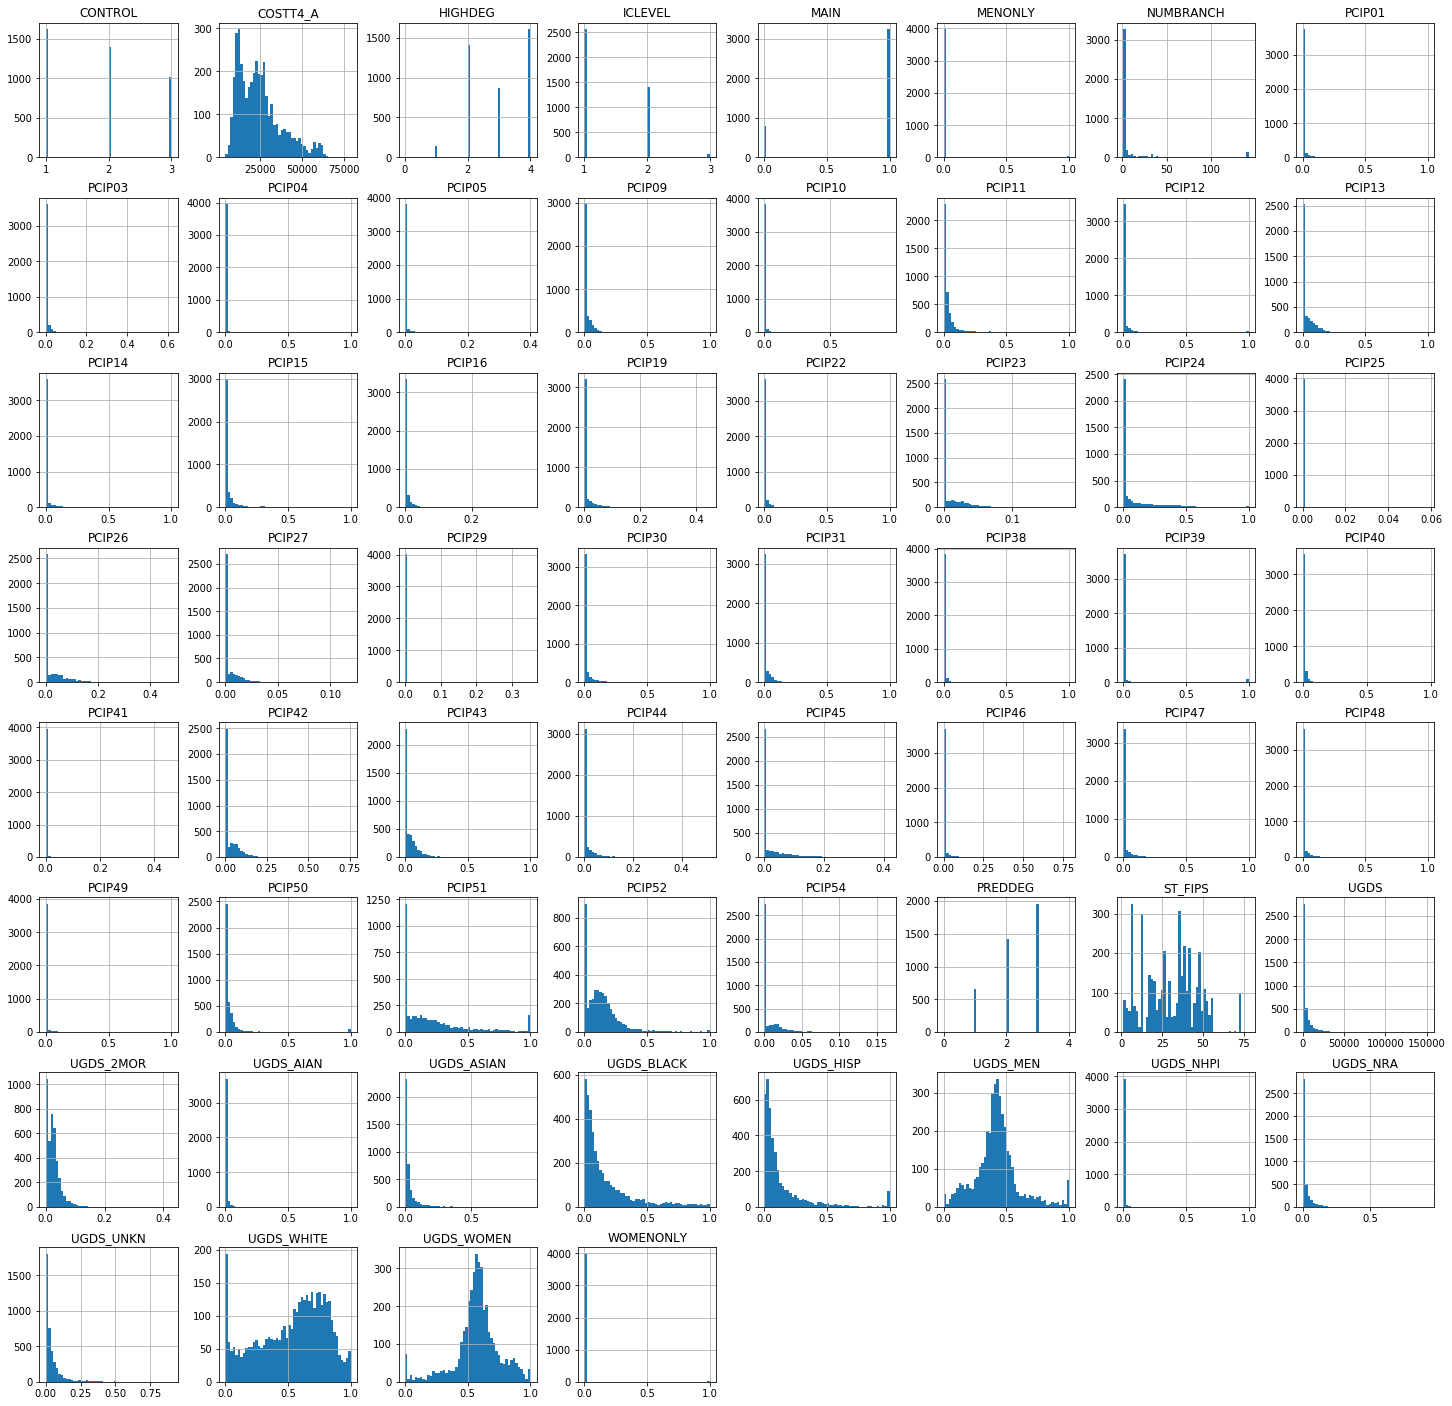

In [9]:
%matplotlib inline 
import matplotlib.pyplot as plt
college2014.hist(bins=50, figsize=(25,25))
plt.show()

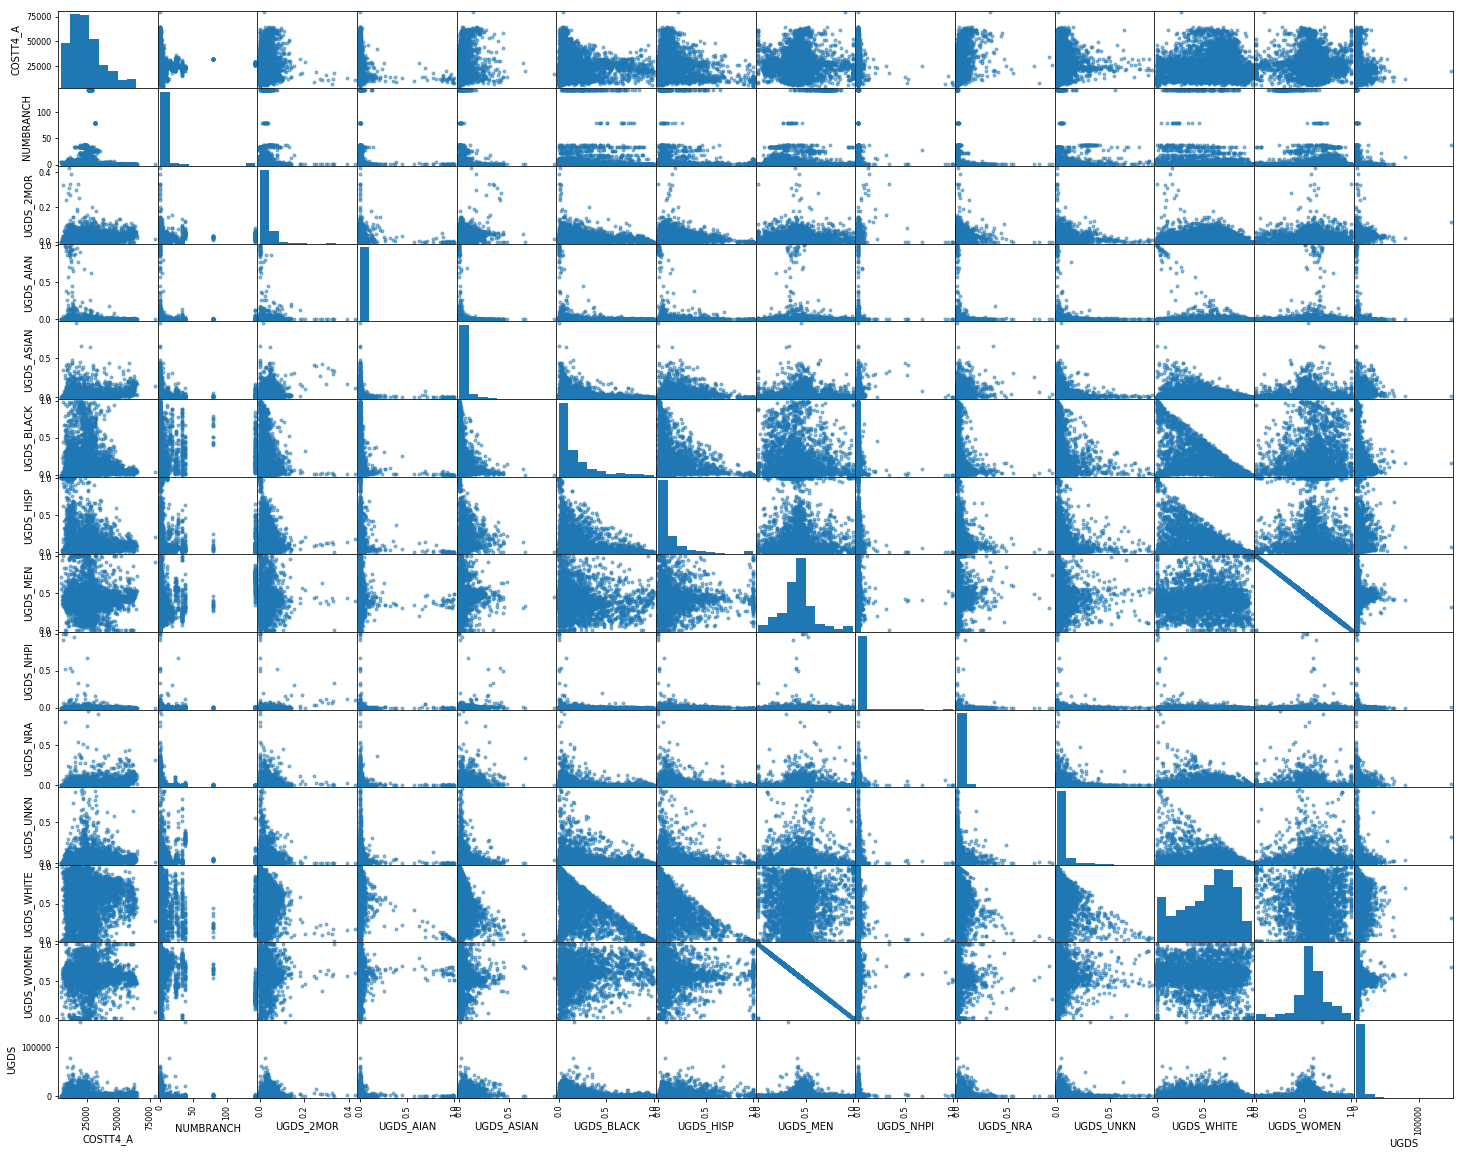

In [10]:
from pandas.tools.plotting import scatter_matrix

attributes = ["COSTT4_A", "NUMBRANCH","UGDS_2MOR", "UGDS_AIAN", "UGDS_ASIAN",
              "UGDS_BLACK", "UGDS_HISP", "UGDS_MEN", "UGDS_NHPI", "UGDS_NRA",
              "UGDS_UNKN", "UGDS_WHITE", "UGDS_WOMEN","UGDS"]

scatter_matrix(college2014[attributes], figsize=(25, 20))
plt.show()

Not much correlation but at least we can see we don't need both UGDS woman and man. 

It seems UGDS_MEN and UGDS_WOMAN are complementary, let's see

In [64]:
college2014[["UGDS_MEN","UGDS_WOMEN"]].head()

,UGDS_MEN,UGDS_WOMEN
0,0.4831,0.5169
1,0.4169,0.5831
2,0.3986,0.6014
3,0.5733,0.4267
4,0.3877,0.6123


Lets check how many missing values we have (many different ways of doing it):

In [108]:
college2014.drop("UGDS_WOMEN", 1, inplace=True)

In [12]:
corr_matrix = college2014.corr()
corr_matrix.COSTT4_A[corr_matrix.COSTT4_A > 0.4]

COSTT4_A    1.000000
CONTROL     0.419594
PREDDEG     0.446358
HIGHDEG     0.472824
PCIP23      0.435106
PCIP26      0.425463
PCIP45      0.423912
PCIP54      0.407869
Name: COSTT4_A, dtype: float64

In [13]:
corr_matrix["COSTT4_A"].sort_values(ascending=False)[:20]

COSTT4_A      1.000000
HIGHDEG       0.472824
PREDDEG       0.446358
PCIP23        0.435106
PCIP26        0.425463
PCIP45        0.423912
CONTROL       0.419594
PCIP54        0.407869
PCIP27        0.390279
UGDS_NRA      0.316150
PCIP16        0.301164
PCIP42        0.281417
PCIP09        0.260761
PCIP50        0.256138
PCIP40        0.234919
PCIP14        0.159936
UGDS_ASIAN    0.158252
PCIP05        0.154433
WOMENONLY     0.147541
UGDS_UNKN     0.115186
Name: COSTT4_A, dtype: float64

In [ ]:
(college2014.isnull().sum() != 0).sum() #how many attributes have non-0 missing values

In [111]:
college2014.isnull().sum()[(college2014.isnull().sum()) != 0] # which columns has missing values different than 0

Series([], dtype: int64)

Split the dataset into a train set `train_set` and a test set `test_set`. 

In [112]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(college2014, test_size=0.2, random_state=42)
print(train_set.shape)
print(test_set.shape)

(3224, 59)
(806, 59)


some plots!!

There are many categorical variables already encoded with numbers but this implies order so we need to convert to one-hot-encoding. We can recognice the features that need to be converted because they will be int64:

In [113]:
college2014.info()    

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4030 entries, 0 to 7281
Data columns (total 59 columns):
COSTT4_A      4030 non-null float64
CONTROL       4030 non-null int64
MAIN          4030 non-null int64
ST_FIPS       4030 non-null float64
ICLEVEL       4030 non-null int64
NUMBRANCH     4030 non-null int64
PREDDEG       4030 non-null int64
HIGHDEG       4030 non-null int64
MENONLY       4030 non-null float64
WOMENONLY     4030 non-null float64
PCIP01        4030 non-null float64
PCIP03        4030 non-null float64
PCIP04        4030 non-null float64
PCIP05        4030 non-null float64
PCIP09        4030 non-null float64
PCIP10        4030 non-null float64
PCIP11        4030 non-null float64
PCIP12        4030 non-null float64
PCIP13        4030 non-null float64
PCIP14        4030 non-null float64
PCIP15        4030 non-null float64
PCIP16        4030 non-null float64
PCIP19        4030 non-null float64
PCIP22        4030 non-null float64
PCIP23        4030 non-null float64
PCIP2

We can create a function that takes the data frame, check for these columns, do one-hot and returns the new dataframe 

In [15]:
from sklearn.preprocessing import OneHotEncoder

#["CONTROL","ICLEVEL","PREDDEG",'HIGHDEG','ST_FIPS'] 

college2014.reset_index(drop=True,inplace=True)

encoder = OneHotEncoder(sparse=False)

CONTROL = encoder.fit_transform(college2014["CONTROL"].reshape(-1, 1))
control_df = pd.DataFrame(CONTROL, columns=["CONTROL1","CONTROL2","CONTROL3"]).reset_index(drop=True)
college2014 = pd.concat([college2014, control_df], axis=1)
college2014.drop("CONTROL",axis=1,inplace=True)

ICLEVEL = encoder.fit_transform(college2014["ICLEVEL"].reshape(-1, 1))
iclevel_df = pd.DataFrame(ICLEVEL, columns=["ICLEVEL1","ICLEVEL2","ICLEVEL3"]).reset_index(drop=True)
college2014 = pd.concat([college2014, iclevel_df], axis=1)
college2014.drop("ICLEVEL",axis=1,inplace=True)

PREDDEG = encoder.fit_transform(college2014["PREDDEG"].reshape(-1, 1))
preddeg_df = pd.DataFrame(PREDDEG, columns=["PREDDEG0","PREDDEG1","PREDDEG2","PREDDEG3","PREDDEG4"]).reset_index(drop=True)
college2014 = pd.concat([college2014, preddeg_df], axis=1)
college2014.drop("PREDDEG",axis=1,inplace=True)

HIGHDEG = encoder.fit_transform(college2014["HIGHDEG"].reshape(-1, 1))
highdeg_df = pd.DataFrame(HIGHDEG, columns=["HIGHDEG0","HIGHDEG1","HIGHDEG2","HIGHDEG3","HIGHDEG4"]).reset_index(drop=True)
college2014 = pd.concat([college2014, highdeg_df], axis=1)
college2014.drop("HIGHDEG",axis=1,inplace=True)

ST_FIPS = encoder.fit_transform(college2014["ST_FIPS"].reshape(-1, 1))
st_fips_df = pd.DataFrame(ST_FIPS).reset_index(drop=True)
college2014 = pd.concat([college2014, st_fips_df], axis=1)
college2014.drop("ST_FIPS",axis=1,inplace=True)

In [17]:
college2014.shape

(4030, 130)

In [19]:
HIGHDEG

array([[ 0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  1.],
       ..., 
       [ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.]])

### Custom transformers

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [ ]:
from sklearn.pipeline import FeatureUnion

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('label_binarizer', LabelBinarizer()),
    ])

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [ ]:
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

In [ ]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:\t", lin_reg.predict(some_data_prepared))
print("Labels:\t\t", list(some_labels))

In [ ]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

In [ ]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

In [ ]:
from sklearn.model_selection import cross_val_score
tree_scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-tree_scores)

In [ ]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)


In [ ]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)

lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)
forest_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, forest_predictions)
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
forest_rmse_scores
display_scores(forest_rmse_scores)

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error')

grid_search.fit(housing_prepared, housing_labels)

In [ ]:
grid_search.best_params_

In [ ]:
grid_search.best_estimator_

In [ ]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

In [ ]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

In [ ]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)   # => evaluates to 48,209.6
final_rmse

The end